In [1]:
import cv2
import mahotas
import imutils
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

In [2]:
#you might need to install mahotas: pip install mahotas 

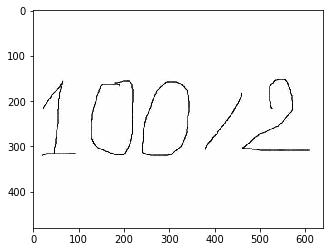

In [95]:
image = cv2.imread('test_5.jpg')

plt.imshow(imutils.opencv2matplotlib(image))
plt.show()

In [4]:
from skimage import feature

class HOG:
    def __init__(self, orientations=9, pixels_per_cell=(8,8), cells_per_block=(3,3), transform=False):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.transform = transform

    def describe(self, image):
        hist = feature.hog(image,
            orientations=self.orientations,
            pixels_per_cell=self.pixels_per_cell,
            cells_per_block=self.cells_per_block,
            transform_sqrt=self.transform)
        return hist

In [5]:
def deskew(image, width):
    (h, w) = image.shape[:2]
    moments = cv2.moments(image)

    skew = moments['mu11'] / moments['mu02']
    M = np.float32([[1, skew, -0.5*w*skew],
                    [0, 1, 0]])
    image = cv2.warpAffine(image, M, (w, h), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)

    image = imutils.resize(image, width=width)

    return image

def center_extent(image, size):
    (eW, eH) = size

    if image.shape[1] > image.shape[0]:
        image = imutils.resize(image, width=eW)
    else:
        image = imutils.resize(image, height=eH)

    extent = np.zeros((eH, eW), dtype='uint8')
    offsetX = (eW - image.shape[1]) // 2
    offsetY = (eH - image.shape[0]) // 2
    extent[offsetY:offsetY + image.shape[0], offsetX:offsetX+image.shape[1]] = image

    CM = mahotas.center_of_mass(extent)
    (cY, cX) = np.round(CM).astype("int32")
    (dX, dY) = ((size[0]//2) - cX, (size[1] // 2) - cY)
    M = np.float32([[1, 0, dX], [0, 1, dY]])
    extent = cv2.warpAffine(extent, M, size)

    return extent

In [7]:
model = tf.keras.models.load_model('cnn_math_v1.h5')

In [7]:
hog = HOG(orientations=18, pixels_per_cell=(10,10), cells_per_block=(1,1), transform=True)

In [100]:
image = cv2.imread('test_5.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (5,5), 0)
# edged = cv2.Canny(blurred, 30, 150)
# Threshold the image
# ret, edged = cv2.threshold(blurred, 120, 255, cv2.THRESH_BINARY_INV)
edged = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = sorted([(c, cv2.boundingRect(c)[0]) for c in  cnts], key=lambda x: x[1])

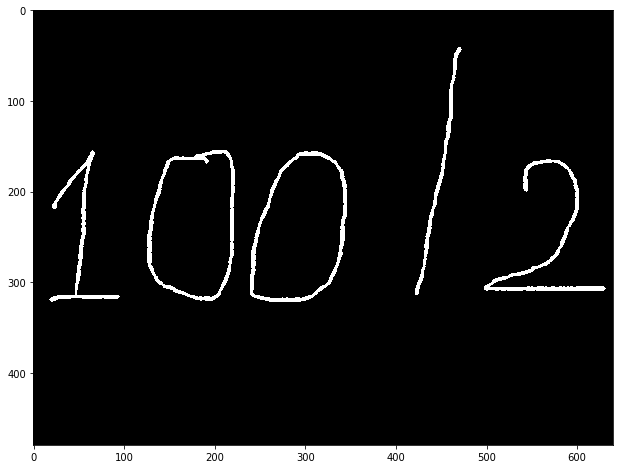

In [101]:
plt.figure(figsize=(12,8))
plt.imshow(imutils.opencv2matplotlib(edged))
plt.show()

In [72]:
label_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'addition',
       'division', 'multiplication', 'subtraction']

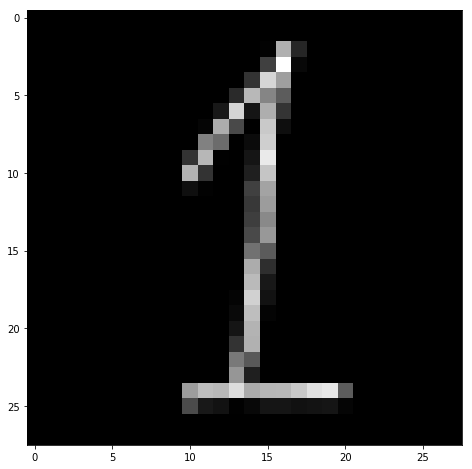

[7.7368750e-06 9.9738222e-01 6.2249886e-04 9.1989677e-05 4.3961718e-06
 4.0046137e-07 7.7488556e-07 3.7501122e-05 1.3595691e-05 6.9281210e-05
 1.8982002e-05 1.0851056e-05 1.7394080e-03 3.7463300e-07]


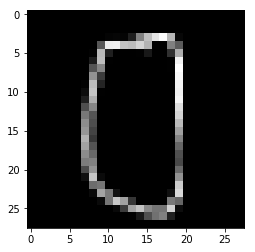

[9.99963284e-01 4.39682140e-08 2.66761253e-05 1.15412915e-08
 8.51747700e-07 4.91885768e-11 1.75342234e-06 3.04088204e-08
 7.43806777e-06 9.41145703e-11 2.22618191e-09 3.72406614e-13
 3.99965366e-10 1.20172882e-11]


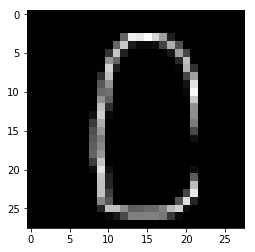

[9.9335456e-01 6.6046305e-06 2.1598844e-05 5.0363752e-07 1.0062745e-07
 3.1633332e-09 7.8765035e-04 1.6927761e-07 5.7520177e-03 2.7422289e-10
 7.6810422e-05 1.1521656e-09 1.2962432e-08 5.5874078e-10]


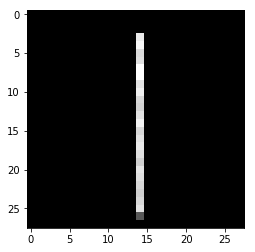

[1.4864623e-03 9.6110755e-01 2.3918075e-03 5.9512298e-04 2.1525394e-04
 7.8104698e-05 2.1172139e-06 2.5394396e-03 2.3516600e-06 5.8261430e-05
 1.5881202e-04 2.9344063e-02 9.9489087e-05 1.9211512e-03]


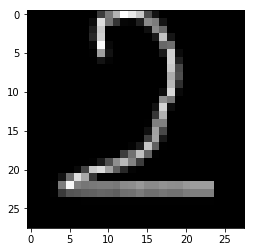

[6.87409352e-10 4.13669515e-11 1.00000000e+00 1.26334445e-08
 1.40558926e-10 3.18475037e-13 3.17049234e-11 4.37988241e-08
 5.62618944e-11 4.97450518e-12 1.07136973e-10 3.42207207e-10
 1.44842444e-10 1.34120728e-10]


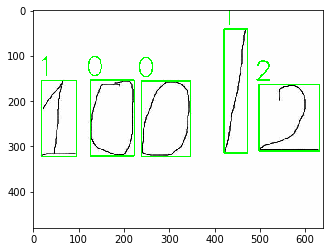

In [102]:
plt.figure(figsize=(12,8))
math_detect = []
for (c, _) in cnts:
    (x, y, w, h) = cv2.boundingRect(c)

    if w >=7 and h>=20:
        roi = edged[y:y+int(1.2*h), x:x+w]
        thresh = roi.copy()

        thresh = deskew(thresh, 28)
        thresh = center_extent(thresh, (28, 28))
        thresh = np.reshape(thresh, (28, 28, 1))
        thresh = thresh / 255
        plt.imshow(thresh[:,:,0], cmap='gray')
        plt.show()

#         cv2.imshow('thresh', thresh)

#         hist = hog.describe(thresh)
#         digit = model.predict([hist])[0]
#         print("Prediction {}".format(digit))
        # Predict
#         label_names = np.array(label_names)
#         predicted_batch = model.predict(image_batch)
#         predicted_id = np.argmax(predicted_batch, axis=1)
#         predicted_label_batch = label_names[predicted_id]

#         predictions = model.predict(np.expand_dims(thresh, axis=0))
        predictions = model.predict(np.expand_dims(thresh, axis=0))
        digit = np.argmax(predictions[0])
        print(predictions[0])

        cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(image, label_names[digit], (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2)
        math_detect.append(label_names[digit])
#         cv2.imshow("image", image)
#         cv2.waitKey(0)
        plt.imshow(imutils.opencv2matplotlib(image))

plt.show()       

### {'+': 0, '-': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'div': 12, 'times': 13}
{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'addition': 10,
 'division': 11,
 'multiplication': 12,
 'subtraction': 13}

In [74]:
def convert_math(math_detect):
    for i in range(0, len(math_detect)):
#         if math_detect[i] == 0:
#             math_detect[i] = '+'
#         elif math_detect[i] == 1:
#             math_detect[i] = '-'
#         elif math_detect[i] == 2:
#             math_detect[i] = '0'
#         elif math_detect[i] == 3:
#             math_detect[i] = '1'
#         elif math_detect[i] == 4:
#             math_detect[i] = '2'
#         elif math_detect[i] == 5:
#             math_detect[i] = '3'
#         elif math_detect[i] == 6:
#             math_detect[i] = '4'
#         elif math_detect[i] == 7:
#             math_detect[i] = '5'
#         elif math_detect[i] == 8:
#             math_detect[i] = '6'
#         elif math_detect[i] == 9:
#             math_detect[i] = '7'
#         elif math_detect[i] == 10:
#             math_detect[i] = '8'
#         elif math_detect[i] == 11:
#             math_detect[i] = '9'
#         elif math_detect[i] == 12:
#             math_detect[i] = '/'
#         elif math_detect[i] == 13:
#             math_detect[i] = '*'
        if math_detect[i] == 'addition':
            math_detect[i] = '+'
        elif math_detect[i] == 'division':
            math_detect[i] = '/'
        elif math_detect[i] == 'multiplication':
            math_detect[i] = '*'
        elif math_detect[i] == 'subtraction':
            math_detect[i] = '-'
    return math_detect

In [81]:
def calculate_string(math_detect):
    math_detect = convert_math(math_detect)
    calculator = ''.join(str(item) for item in math_detect)
    print(calculator + ' = ' + str(eval(calculator)))

In [103]:
calculate_string(math_detect)

10012 = 10012
